In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import proplot as pplt

## Look at n(z) Distributions and Perturbations

In [3]:
with h5py.File("/Users/beckermr/Desktop/sompz_y6_imsim_400Tile.hdf5") as d:
    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"catalog/sompz/pzdata/bin{_bin}"][:]
    zlow = d["catalog/sompz/pzdata/zlow"][:]
    zhigh = d["catalog/sompz/pzdata/zhigh"][:]
    z = (zlow + zhigh)/2
    dz = z[1] - z[0]

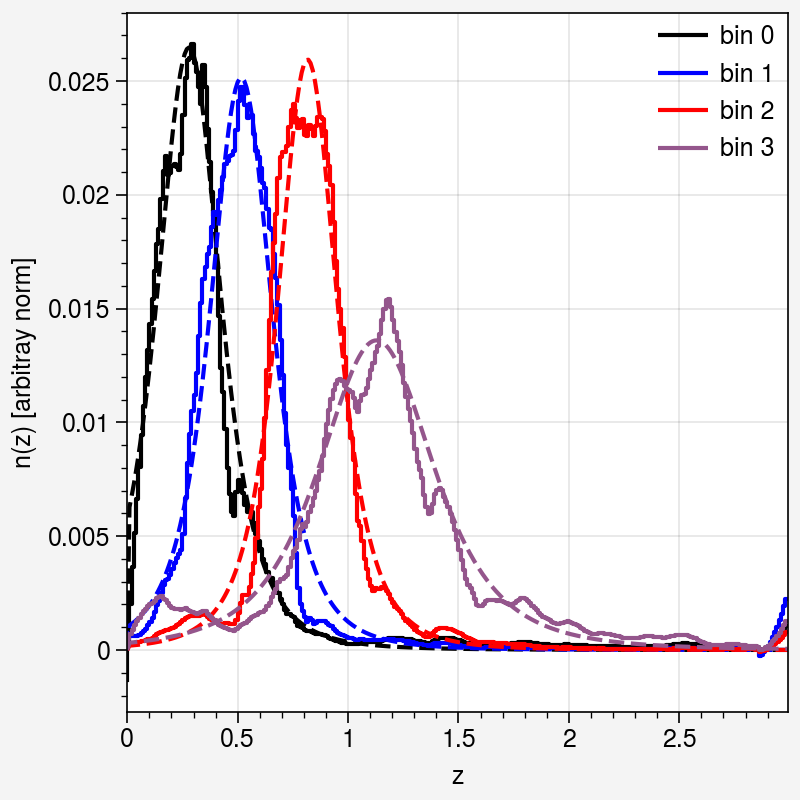

In [4]:
from des_y6_nz_modeling import fit_nz_data_for_template_params, mstudt_nrm, ZVALS

params = fit_nz_data_for_template_params(nzs)

fig, axs = pplt.subplots(figsize=(4, 4))

for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt = params[i]
    axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, mstudt_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

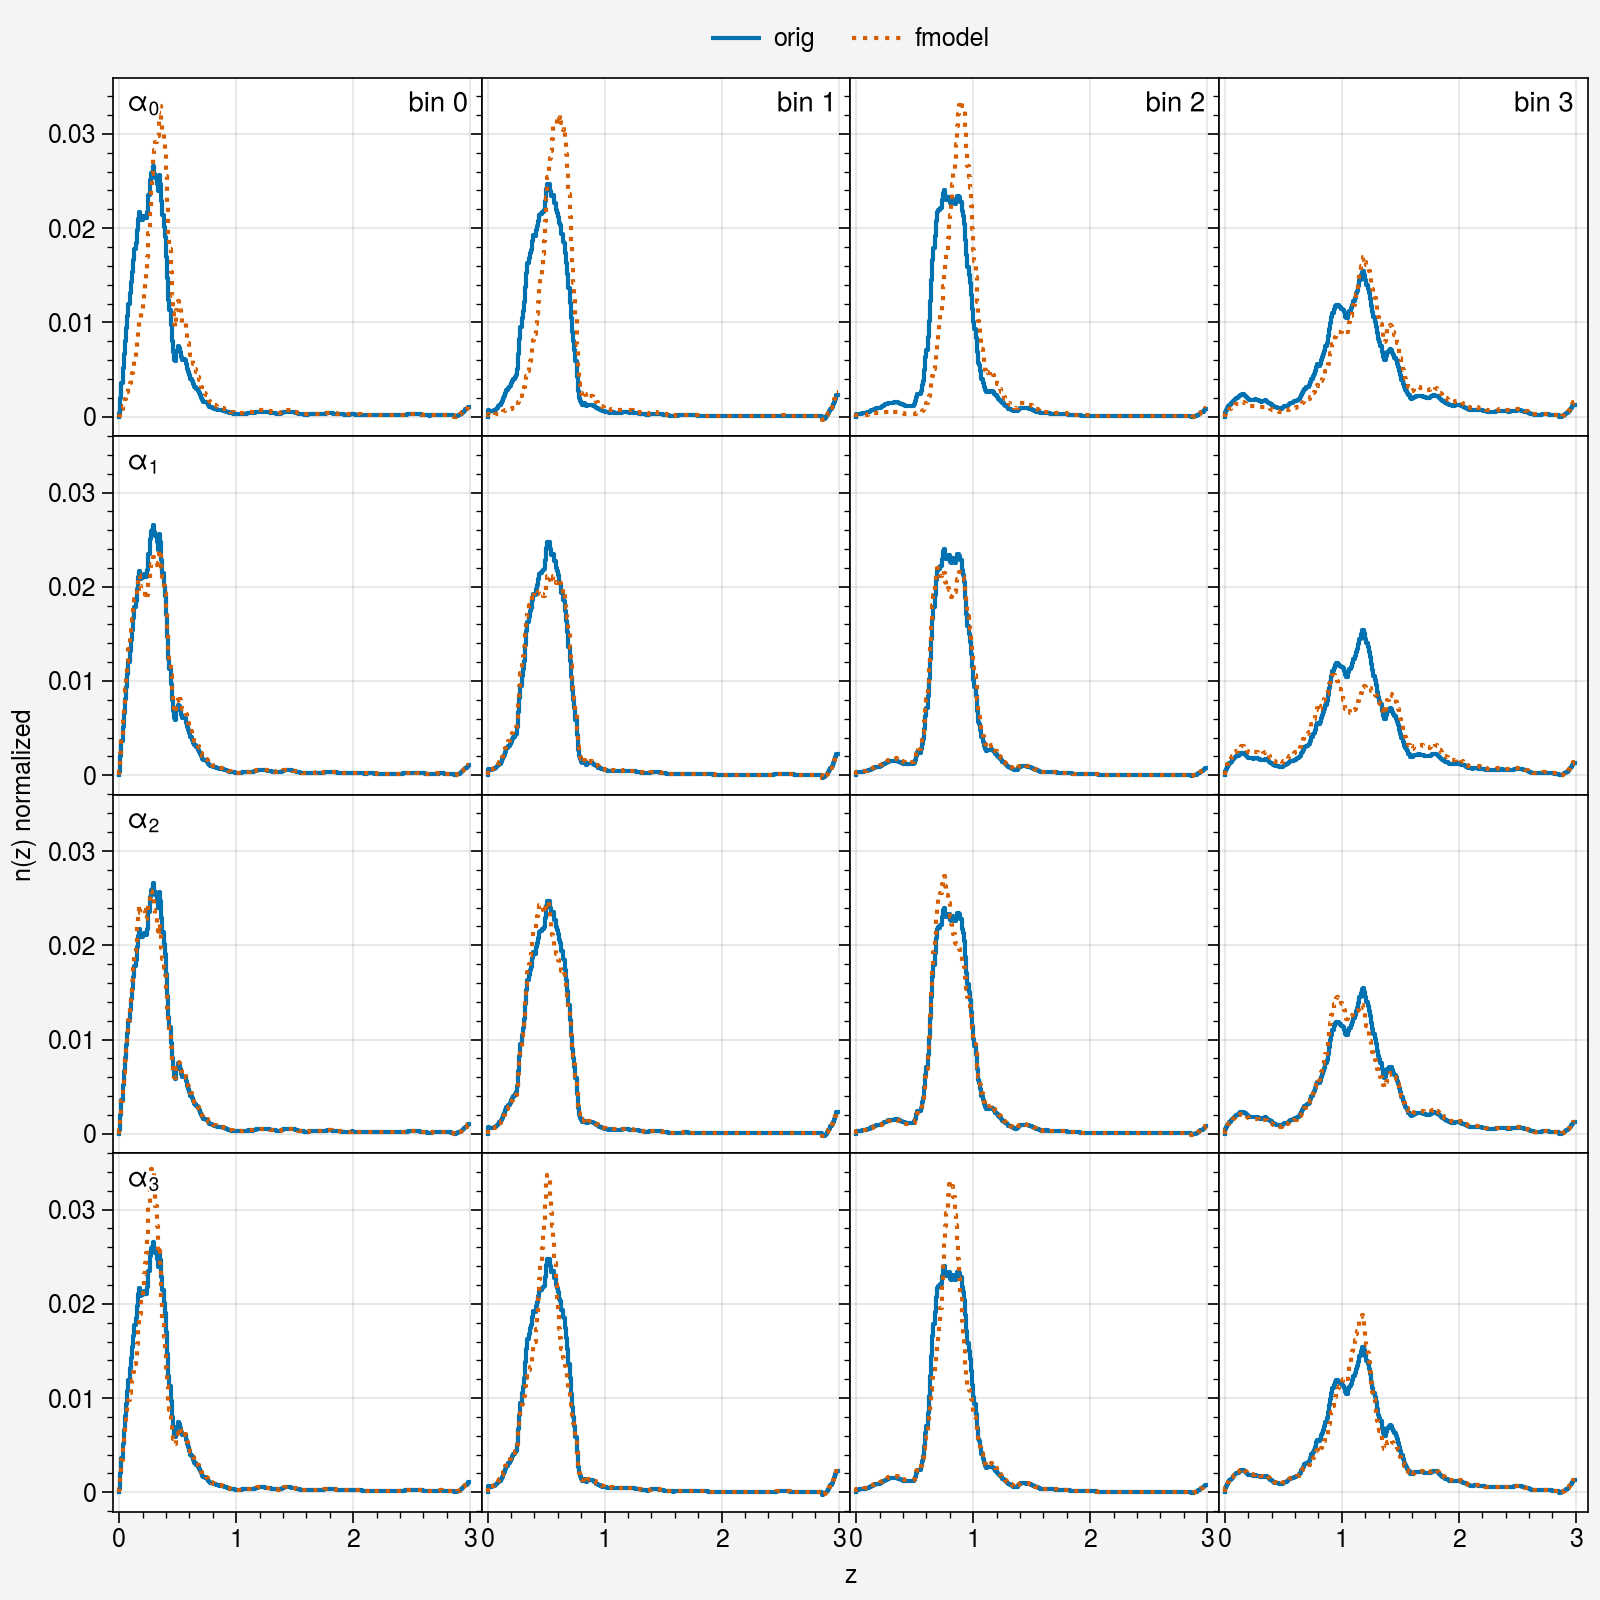

In [5]:
from des_y6_nz_modeling import fmodel_mstudt4

scales = np.array([1e-1, 5e-3, 1e-3, 5e-4])

fig, axs = pplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]
        if i == 3 and row > 0:
            avec *= 10

        nzi = nzs[i].astype(np.float64).copy()
        nzi[0] = 0.0
        nzi = nzi / np.sum(nzi)
        stud_params = params[i]

        morig = ax.plot(z, nzi, drawstyle="steps", label="orig")

        fac = 1.0 + fmodel_mstudt4(z, 0.0, avec[0], avec[1], avec[2], avec[3], stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= np.sum(nzi_fmodel)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # fac = 1.0 + fmodel_stud4(z, 0.0, 0e-1, 0e-3, 0e-3, 0e-4, stud_params[0], stud_params[1])
        # nzi_fmodel = nzi * fac
        # nzi_fmodel /= np.sum(nzi_fmodel)
        # mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # axs.plot(z, fac, linestyle="dotted")
        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Try a Tomographic Fit with a Diagonal Covariance Matrix

In [6]:
import io

data0 = """\
alpha zlow zhigh N_mean N_cov
0 0.0 0.3 0.43309948750617455 1.0465121854434392e-05
1 0.3 0.6 0.3497950417057848 1.3660992667964714e-05
2 0.6 0.9 0.028689322095422024 3.5106550649570966e-06
3 0.9 1.2 0.00533064697459332 2.1645428685273393e-06
4 1.2 1.5 0.005066966096029153 1.6474467642141326e-06
5 1.5 1.8 0.002705985516685974 1.0003907765054144e-06
6 1.8 2.1 0.002192262772164886 7.170029247572135e-07
7 2.1 2.4 0.0015982203561405956 5.535556438617457e-07
8 2.4 2.7 0.0013949066529881815 4.084510426877782e-07
9 2.7 6.0 0.0038094011256517312 7.760373423943713e-07
"""

data1 = """\
alpha zlow zhigh N_mean N_cov
0 0.0 0.3 0.08452891830983007 7.295729998558241e-06
1 0.3 0.6 0.5343689539108235 2.308649764462785e-05
2 0.6 0.9 0.17551107722871523 1.1931628303600458e-05
3 0.9 1.2 0.009061359044013416 3.5866680469400992e-06
4 1.2 1.5 0.004052262309771469 1.8316388489111341e-06
5 1.5 1.8 0.0011654605090659128 1.18781609049302e-06
6 1.8 2.1 0.0005563517863981035 9.327193820799611e-07
7 2.1 2.4 0.00046716980578550535 6.408363505287271e-07
8 2.4 2.7 0.001103060781968704 5.741762229045461e-07
9 2.7 6.0 0.0005537254774424048 1.4581976183650101e-06
"""

data2 = """\
alpha zlow zhigh N_mean N_cov
0 0.0 0.3 0.029335490009428086 3.329194442659293e-06
1 0.3 0.6 0.061809118572129285 6.198389509392238e-06
2 0.6 0.9 0.47160749583232553 1.6350764430222163e-05
3 0.9 1.2 0.1769046172276786 8.695746688679031e-06
4 1.2 1.5 0.014101117161050133 2.1777781403533995e-06
5 1.5 1.8 0.003720804367855154 1.2828590361277371e-06
6 1.8 2.1 0.0007865134336105988 7.077607000435771e-07
7 2.1 2.4 0.0008374832324775123 4.853854212723248e-07
8 2.4 2.7 0.0005369902451712841 3.958264868405327e-07
9 2.7 6.0 0.0017147990269802498 9.931864868464358e-07
"""

data3 = """\
alpha zlow zhigh N_mean N_cov
0 0.0 0.3 0.05396024309599687 8.14043431066152e-06
1 0.3 0.6 0.029009412076102765 8.787147206405298e-06
2 0.6 0.9 0.09824113341929426 1.406943543081783e-05
3 0.9 1.2 0.24730596078857858 2.0432648002533004e-05
4 1.2 1.5 0.1360547998488426 1.2990650533826215e-05
5 1.5 1.8 0.03268760062871496 5.234837894355402e-06
6 1.8 2.1 0.015446715047464489 3.4529690091060603e-06
7 2.1 2.4 0.007748742636968015 1.9590888402297973e-06
8 2.4 2.7 0.004647261264808825 1.3752720944949965e-06
9 2.7 6.0 0.0036435523916366593 2.2632881678707325e-06
"""

sdata = {}
for i, data in enumerate([data0, data1, data2, data3]):
    sdata[i] = np.genfromtxt(io.StringIO(data), names=True)

1.0019106100675663
1.0002978695108147
1.0000553469651352
1.0001429709562375
0 0 [-0.04356172]
0 1 [-0.12790692]
0 2 [-0.48418111]
0 3 [-0.50550223]
0 4 [-0.62375542]
0 5 [-0.6785767]
0 6 [-0.70332083]
0 7 [-0.67428219]
0 8 [-0.77184542]
0 9 [-0.48917321]
1 0 [0.11234297]
1 1 [-0.07416851]
1 2 [-0.34106934]
1 3 [-0.48674543]
1 4 [-0.57466765]
1 5 [-0.6995333]
1 6 [-0.76785584]
1 7 [-0.65937304]
1 8 [-0.54588555]
1 9 [-0.94090593]
2 0 [0.36101327]
2 1 [0.22267452]
2 2 [-0.18248901]
2 3 [-0.33051563]
2 4 [-0.54619788]
2 5 [-0.67112325]
2 6 [-0.79875516]
2 7 [-0.44950244]
2 8 [-0.68034596]
2 9 [-0.52012521]
3 0 [0.07925213]
3 1 [-0.21874833]
3 2 [-0.19561409]
3 3 [-0.28880751]
3 4 [-0.46506279]
3 5 [-0.53842458]
3 6 [-0.61613103]
3 7 [-0.57531551]
3 8 [-0.66964174]
3 9 [-0.59949033]


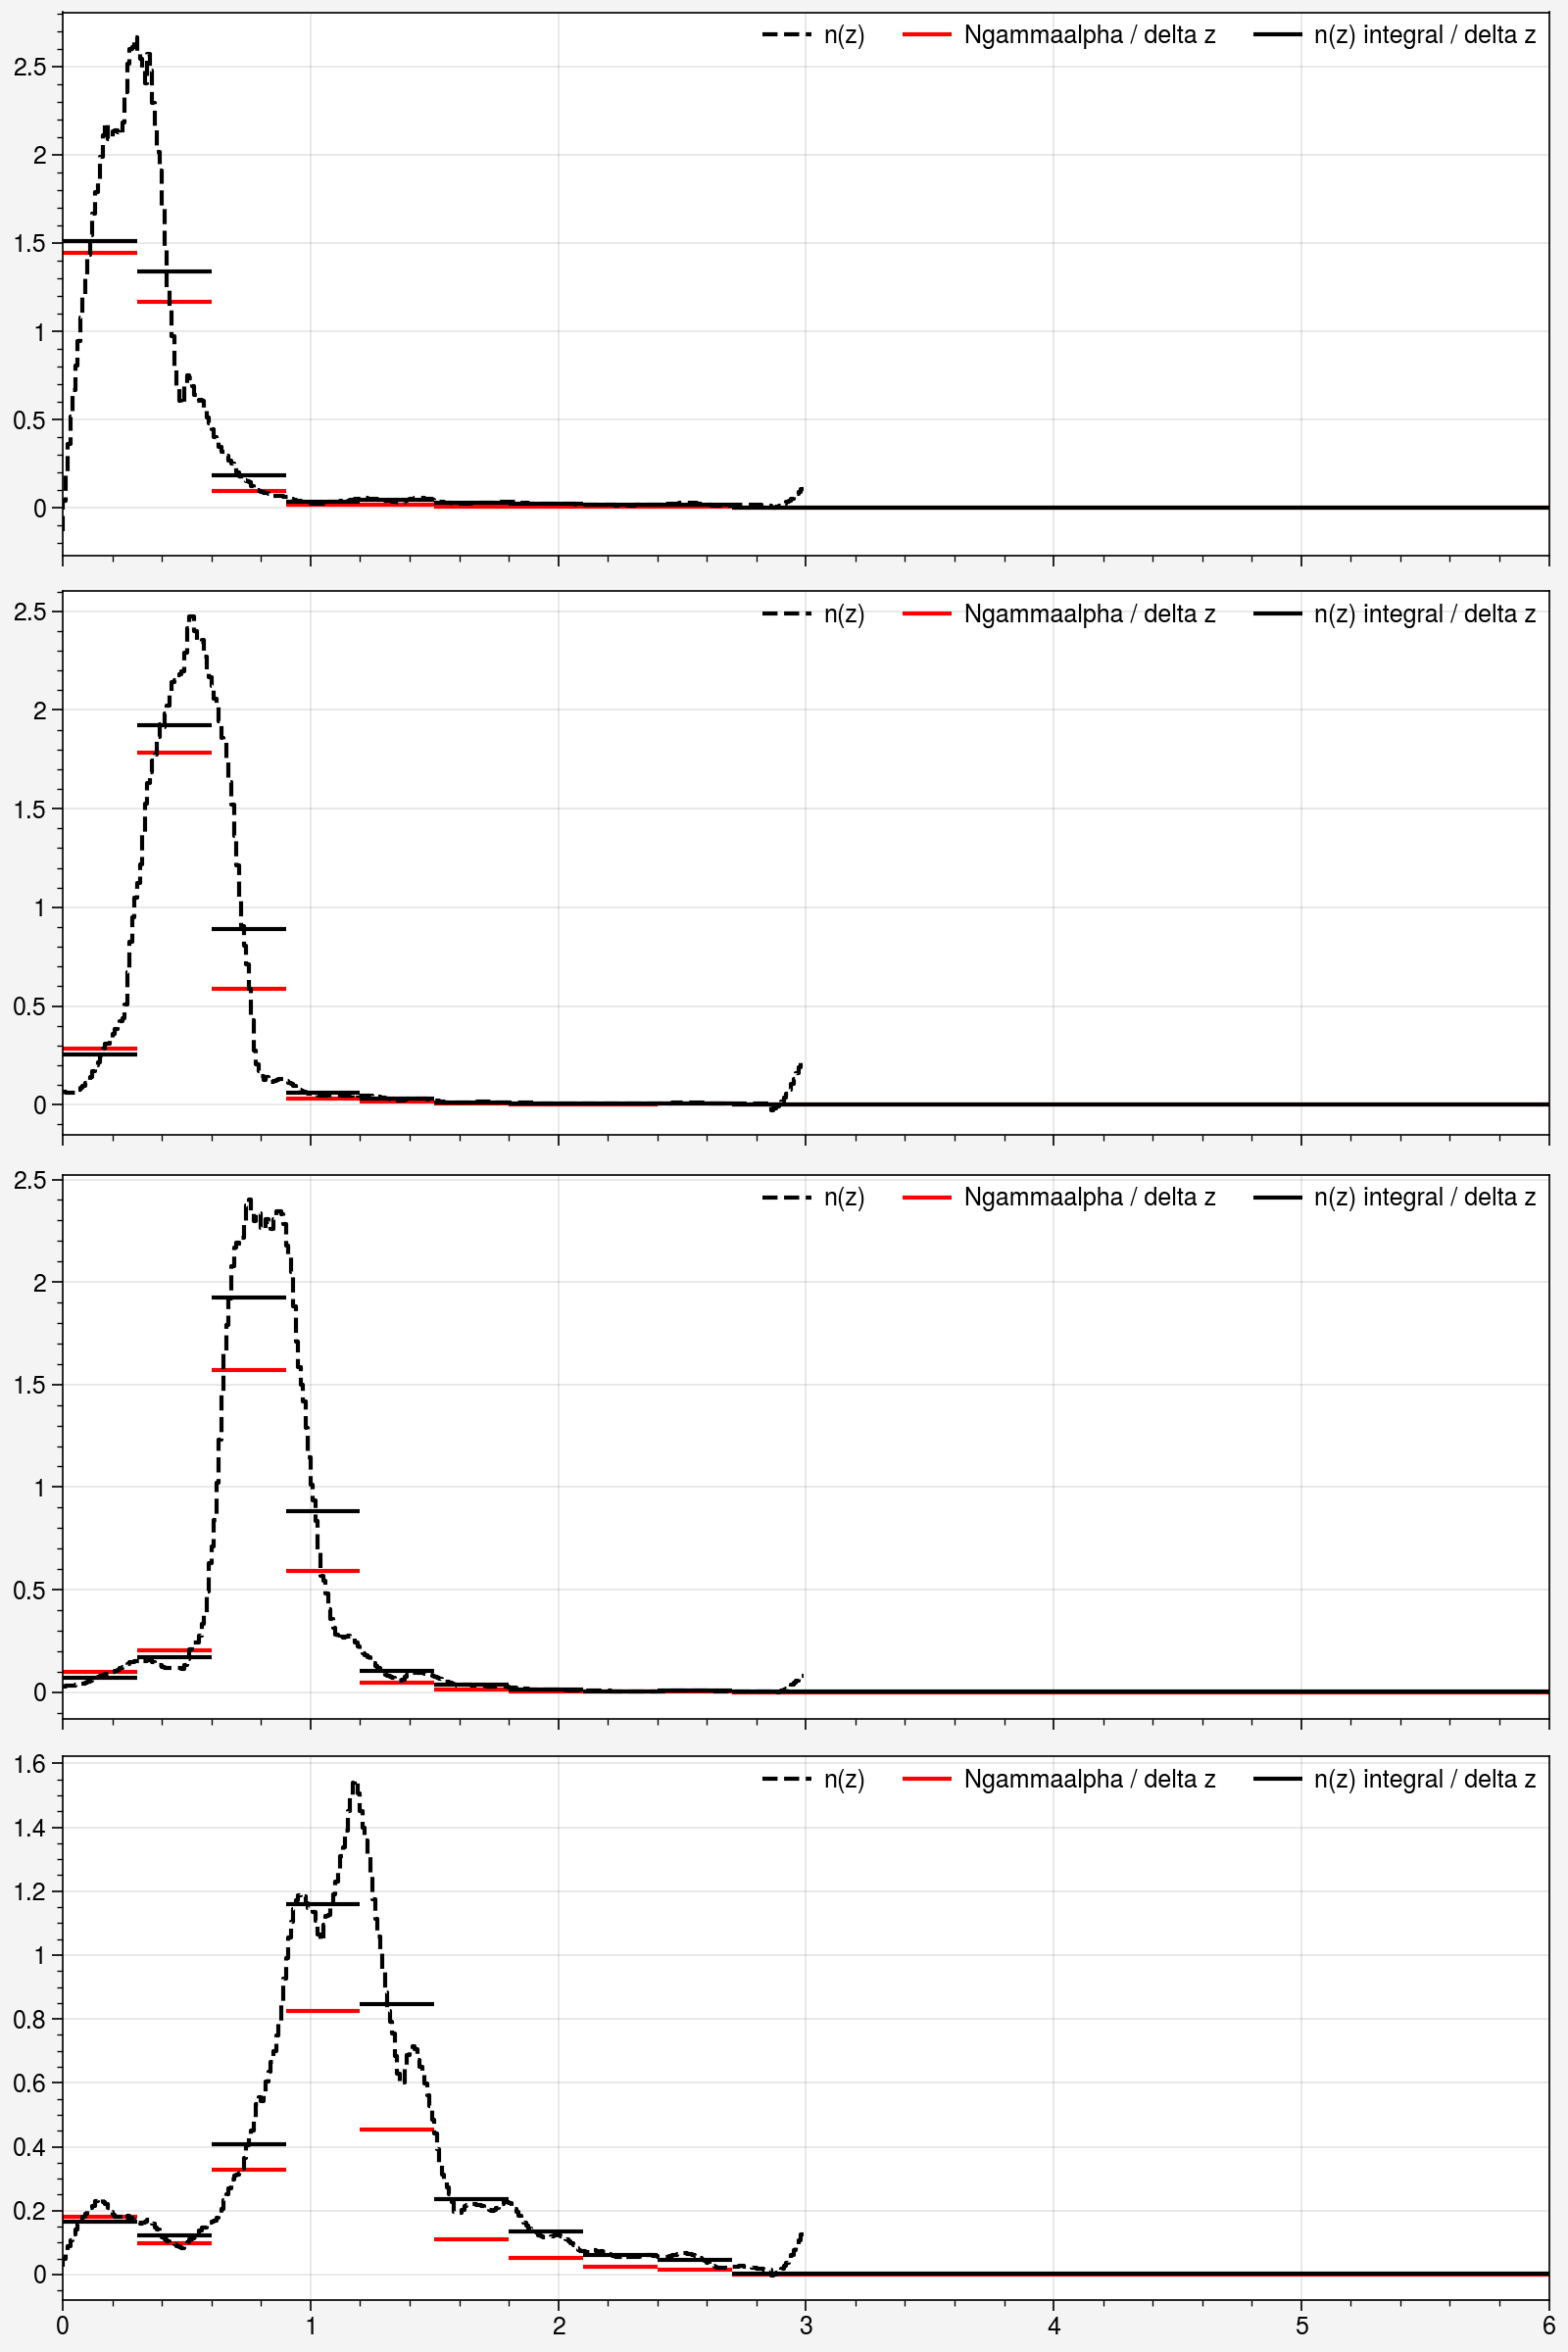

In [78]:
fig, axs = pplt.subplots(nrows=4, ncols=1, figsize=(8, 12))
nzs_norm = []
for i in range(4):
    nz = nzs[i].astype(np.float64).copy()
    # nz[0] = 0.0
    # nz = nz / jnp.trapezoid(nz, dx=DZ)
    nzs_norm.append(nz)


for bi in range(4):
    ax = axs[bi, 0]
    ax.plot(ZVALS, nzs_norm[bi], drawstyle="steps", color="black", linestyle="dashed", label="n(z)")

    for i in range(10):
        msk = sdata[bi]["alpha"] == i
        bin_zmin = sdata[bi]["zlow"][msk][0]
        bin_zmax = sdata[bi]["zhigh"][msk][0]
        bin_dz = bin_zmax - bin_zmin
        ax.hlines(
            sdata[bi]["N_mean"][msk] / bin_dz, 
            sdata[bi]["zlow"][msk], 
            sdata[bi]["zhigh"][msk], 
            color="red",
            label="Ngammaalpha / delta z" if i == 0 else None,
        )
        _msk = (ZVALS >= bin_zmin) & (ZVALS < bin_zmax)
        ng_val = jnp.trapezoid(nzs_norm[bi][_msk], dx=DZ) / bin_dz
        ax.hlines(
            ng_val, 
            sdata[bi]["zlow"][msk], 
            sdata[bi]["zhigh"][msk], 
            color="black",
            label="n(z) integral / delta z" if i == 0 else None,
        )
        print(bi, i, sdata[bi]["N_mean"][msk] / bin_dz / ng_val - 1)
    ax.legend(loc="ur", frameon=False)
        

## Try numpyro

In [7]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/beckermr/mambaforge/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
from des_y6_nz_modeling import fmodel_mstudt4, gmodel_template_cosmos, ZVALS, ZBIN_LOW, ZBIN_HIGH, DZ


def model(mu=None, sigma=None, nz=None, N_mean=None, N_cov=None):
    assert mu is not None
    assert sigma is not None
    assert nz is not None
    assert N_mean is not None
    assert N_cov is not None

    pwidth = 0.01
    for i in range(4):
        a0 = numpyro.sample(f"a0_b{i}", dist.Normal(0.0, pwidth))
        a1 = numpyro.sample(f"a1_b{i}", dist.Normal(0.0, pwidth))
        a2 = numpyro.sample(f"a2_b{i}", dist.Normal(0.0, pwidth))
        a3 = numpyro.sample(f"a3_b{i}", dist.Normal(0.0, pwidth))
        a4 = numpyro.sample(f"a4_b{i}", dist.Normal(0.0, pwidth))
        g = numpyro.sample(f"g_b{i}", dist.Normal(0.0, pwidth))
    
        fmod = fmodel_mstudt4(ZVALS, a0, a1, a2, a3, a4, mu[i], sigma[i])
        gmod = g * gmodel_template_cosmos()
        ngamma = (1.0 + fmod) * nz[i] + gmod
        ngamma = jnp.clip(ngamma, 0.0, jnp.inf)
    
        for zi, (zlow, zhigh) in enumerate(zip(ZBIN_LOW, ZBIN_HIGH)):
            msk = (ZVALS >= zlow) & (ZVALS < zhigh)
            ng_val = jnp.trapezoid(ngamma[msk], dx=DZ)
            numpyro.sample(f"N_{zlow}_{zhigh}_b{i}", dist.Normal(loc=ng_val, scale=jnp.sqrt(N_cov[i][zi])), obs=N_mean[i][zi])

In [56]:
nzs_norm = []
for i in range(4):
    nz = nzs[i].astype(np.float64).copy()
    nz[0] = 0.0
    nz = nz / jnp.trapezoid(nz, dx=DZ)
    nzs_norm.append(nz)

model_data = dict(
    mu=tuple(params[i][0] for i in range(4)),
    sigma=tuple(params[i][1] for i in range(4)),
    nz=tuple(nzs_norm),
    N_mean=tuple(sdata[i]["N_mean"].astype(np.float64) for i in range(4)),
    N_cov=tuple(sdata[i]["N_cov"].astype(np.float64) for i in range(4)),
)

## MAP

In [57]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    100000,
    **model_data,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]
print(map_params)

100%|████████████████████████████████████████████████████████████████| 100000/100000 [00:16<00:00, 6200.54it/s, init loss: 13386.2689, avg. loss [95001-100000]: 207.2064]


{'a0_b0': Array(-0.02223484, dtype=float64), 'a0_b1': Array(-0.03652434, dtype=float64), 'a0_b2': Array(-0.08577493, dtype=float64), 'a0_b3': Array(-0.15634425, dtype=float64), 'a1_b0': Array(-0.03540818, dtype=float64), 'a1_b1': Array(-0.01194872, dtype=float64), 'a1_b2': Array(-0.02509118, dtype=float64), 'a1_b3': Array(-0.0926657, dtype=float64), 'a2_b0': Array(-0.00869128, dtype=float64), 'a2_b1': Array(0.00087677, dtype=float64), 'a2_b2': Array(0.00026956, dtype=float64), 'a2_b3': Array(0.02797666, dtype=float64), 'a3_b0': Array(-0.00285456, dtype=float64), 'a3_b1': Array(-0.0039581, dtype=float64), 'a3_b2': Array(-0.00488963, dtype=float64), 'a3_b3': Array(-0.01226504, dtype=float64), 'a4_b0': Array(0.00200251, dtype=float64), 'a4_b1': Array(0.00122181, dtype=float64), 'a4_b2': Array(0.00084607, dtype=float64), 'a4_b3': Array(0.00707654, dtype=float64), 'g_b0': Array(-0.02812306, dtype=float64), 'g_b1': Array(-0.04322692, dtype=float64), 'g_b2': Array(-0.01886153, dtype=float64),

# MCMC

In [58]:
from jax import random
from numpyro.infer import init_to_sample

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model, init_strategy=init_to_sample(), dense_mass=True)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_,
    **model_data,
)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:51<00:00, 58.23it/s, 1023 steps of size 4.10e-03. acc. prob=0.84]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.02      0.01     -0.02     -0.04     -0.01   1360.98      1.00
     a0_b1     -0.04      0.01     -0.04     -0.05     -0.02   1434.74      1.00
     a0_b2     -0.09      0.01     -0.09     -0.10     -0.07   1364.63      1.00
     a0_b3     -0.16      0.01     -0.16     -0.17     -0.14   1836.88      1.00
     a1_b0     -0.04      0.01     -0.04     -0.05     -0.03   1323.52      1.00
     a1_b1     -0.01      0.00     -0.01     -0.02     -0.01   1735.70      1.00
     a1_b2     -0.03      0.00     -0.03     -0.03     -0.02   2059.46      1.00
     a1_b3     -0.09      0.00     -0.09     -0.10     -0.08   1720.46      1.00
     a2_b0     -0.01      0.00     -0.01     -0.01     -0.00    984.85      1.00
     a2_b1      0.00      0.00      0.00     -0.00      0.00   2097.44      1.00
     a2_b2      0.00      0.00      0.00     -0.00      0.00   1928.66      1.00
     a2_b3      0.03      0

## Make a Plot

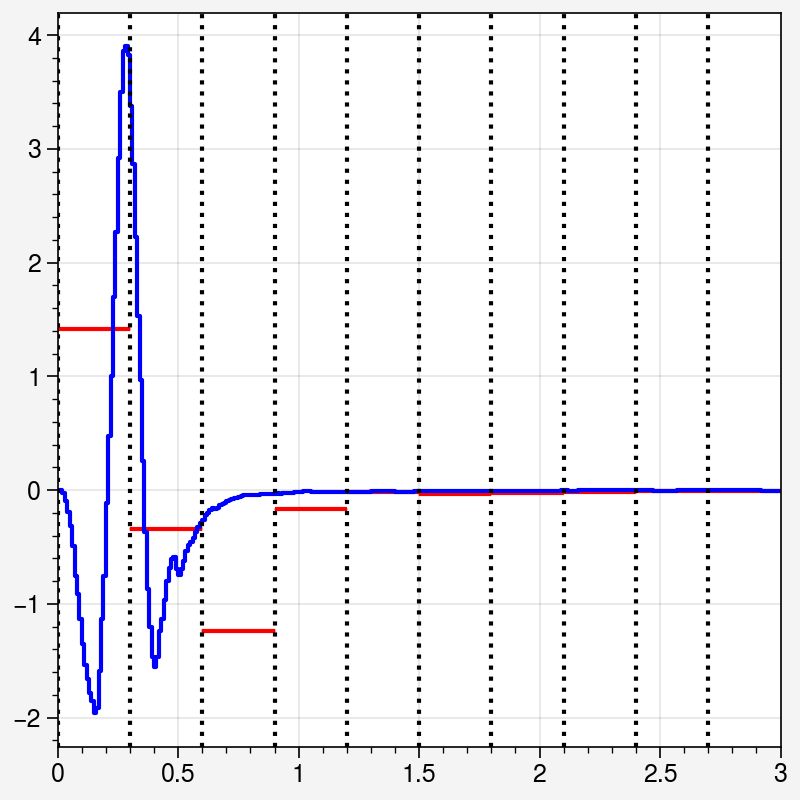

In [59]:
bi = 0

fmod = fmodel_mstudt4(
    ZVALS,
    map_params[f"a0_b{bi}"],
    map_params[f"a1_b{bi}"],
    map_params[f"a2_b{bi}"],
    map_params[f"a3_b{bi}"],
    map_params[f"a4_b{bi}"],
    params[bi][0],
    params[bi][1],
)
gmod = map_params[f"g_b{bi}"] * gmodel_template_cosmos()
ngamma = (1.0 + fmod) * nzs_norm[bi] + gmod
ngamma = jnp.clip(ngamma, 0.0, jnp.inf)

fig, axs = pplt.subplots(figsize=(4, 4))

ax = axs[0, 0]

offset = 1
if offset == 0:
    ax.plot(ZVALS, nzs_norm[bi] - offset * nzs_norm[bi], drawstyle="steps", label="nontomo", color="green")
ax.plot(ZVALS, ngamma - offset * nzs_norm[bi], drawstyle="steps", label="nontomo", color="blue")
for i in range(10):
    _msk = (ZVALS >= bin_zmin) & (ZVALS < bin_zmax)
    ng_val = jnp.trapezoid(nzs_norm[bi][_msk], dx=DZ) / bin_dz
    
    msk = sdata[bi]["alpha"] == i
    bin_zmin = sdata[bi]["zlow"][msk][0]
    bin_zmax = min(sdata[bi]["zhigh"][msk][0], 3.0)
    bin_dz = bin_zmax - bin_zmin
    ax.hlines(
        sdata[bi]["N_mean"][msk] / bin_dz - offset * ng_val, 
        sdata[bi]["zlow"][msk], 
        min(sdata[bi]["zhigh"][msk], 3.0), 
        color="red",
    )
    ax.fill_between(
        np.array([bin_zmin, bin_zmax]),
        sdata[bi]["N_mean"][msk] / bin_dz - np.sqrt(sdata[bi]["N_cov"][msk]) / bin_dz - offset * ng_val,
        sdata[bi]["N_mean"][msk] / bin_dz + np.sqrt(sdata[bi]["N_cov"][msk]) / bin_dz - offset * ng_val,
        color="red",
        alpha=0.5,
    )
    ax.axvline(bin_zmin, color="black", linestyle="dotted")

    if offset == 0:
        ax.hlines(ng_val - offset * ng_val, bin_zmin, bin_zmax, color="green")

    # ax.plot(ZVALS, mstudt_nrm(ZVALS, *params[bi]) / DZ - offset * nzs_norm[bi], linestyle="dashed", color="blue")